# Pistachio Classifier
---
In this notebook I'm trying to classify images from Daniel's collection of good and bad Pistachio nut images, just for some fun real world practice with CNNs for computer vision.

Not quite working yet, the code functions nicely, but need to come up with some more sensible hyperparameters, network architecture, and do a bit of image augmentation.  The loss and optimiser aren't really working at this point, so it's converging to "all good" or "all bad".

There are 54 "bad" nuts, and 66 "good" nuts.  I presume this wasn't a random and representative sample, but has been selected to give me a wide variety within each class and similar class sizes.

The original images are in colour, jpg format, 1500px wide, 1000px high

<table  style="width:95%">
    <tr>
        <td><img src='images/Good/IMG_20190311_151848.jpg' width="90%" /></td>
        <td><img src='images/Bad/IMG_20190311_150011.jpg' width="90%" /></td>   
    </tr>
    <tr>
        <td style="text-align: center">Good</td>
        <td style="text-align: center">Bad</td>
    </tr>
</table>

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

This step is here because my Dell E6430 doesnt have CUDA enabled GPU, but I may use Colab or get a more fancy notebook some day.

In [27]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available :(  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available :(  Training on CPU ...


---
## Load the Data

The data is sitting in seperate folders, one for 'good' nuts, one for 'bad' ones.

In [28]:
from torchvision import datasets as datasets
from torchvision import transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0   # number of subprocesses to use for data loading
batch_size = 20   # how many samples per batch to load

#fraction of full dataset to use as training and validation
train_size = 0.6
valid_size = 0.2

image_size = 32  # size to resize the input images to, keep as a multiple of 2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

full_dataset = datasets.ImageFolder('images/', transform=transform)

# choose the training and test datasets
# train_data = datasets.CIFAR10('data', train=True,
                              #download=True, transform=transform)
# test_data = datasets.CIFAR10('data', train=False,
                             #download=True, transform=transform)

# obtain training indices that will be used for train, validation and test

total_images = len(full_dataset)
indices = list(range(total_images))
np.random.shuffle(indices)
train_sp = int(np.floor(valid_size * total_images)) # The training-validation split
valid_sp = int(np.floor(valid_size * total_images)) + train_sp # The validation-test split
train_idx, valid_idx, test_idx = indices[:train_sp], indices[train_sp:valid_sp], indices[valid_sp:]

print(' Training set size: \t', len(train_idx))
print(' Test set size: \t', len(valid_idx))
print(' Test set size: \t', len(test_idx))
print(' Total dataset: \t', total_images)

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['bad', 'good']

 Training set size: 	 24
 Test set size: 	 24
 Test set size: 	 72
 Total dataset: 	 120


### Visualize a Batch of Training Data

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

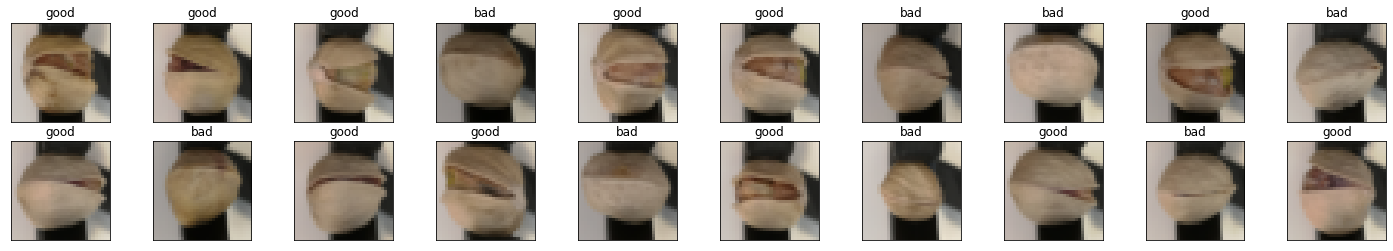

In [30]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display one batch of images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])  # may need to use batch_size/2 for larger 
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

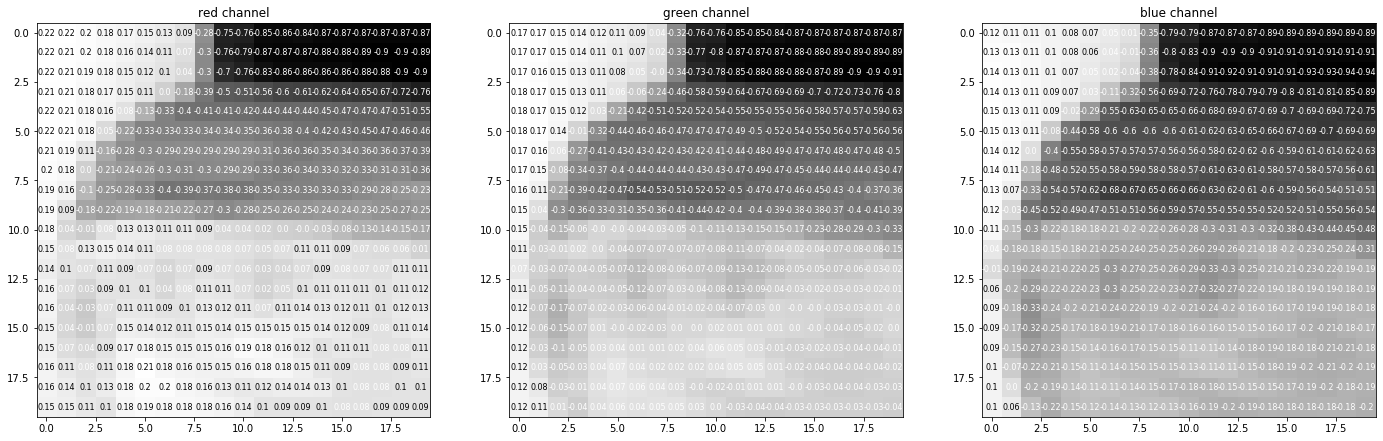

In [36]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (24, 24)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx][0:20, 0:20]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

Just starting out with the architecture I used for CFAR_10

In [32]:
import torch.nn as nn
import torch.nn.functional as F

# define some variables
feature_length = 1024   #64*(image_size/8)**2 # image size/2 for each maxpool layer  4096
hidden_1 = 256
hidden_2 = 128

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 3 Channels, output depth 16, kernel size 3
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # input 16, output depth 32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # input 32, output depth 64
        # fully connected layers
        self.fc1 = nn.Linear(feature_length,hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 2)   # should output the class scores
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x))) #In (32x32x3) Out (16x16x16)
        x = self.pool(F.relu(self.conv2(x)))  #In (16x16x16) Out (8x8x32)
        x = self.pool(F.relu(self.conv3(x)))  #In (8x8x32) Out (4x4x64)
        x = x.view(-1, feature_length)  # re-shape the output in to the feature vector 4x4x64 = 1024
        x = self.dropout(x)
        x = F.relu(self.fc1(x)) # fully connected layer 1
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # fully connected layer 2
        x = self.fc3(x)   # The two output classes
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Specify Loss Function and Optimiser

In [35]:
import torch.optim as optim

# specify loss function
criterion = nn.BCELoss() # was nn.CrossEntropyLoss() for multi-class examples
# something funny going on here,  getting miss-match between output and target tensor size.

# specify optimiser
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum = 0.9)  # Consider changing to adam

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [34]:
# number of epochs to train the model
n_epochs = 15 # May need to increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)     # should be a tensor with torch.size [20,10] if all going well
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_pistachio.pt')
        valid_loss_min = valid_loss

ValueError: Target and input must have the same number of elements. target nelement (20) != input nelement (40)

###  Load the Model with the Lowest Validation Loss

In [ ]:
model.load_state_dict(torch.load('model_pistachio.pt'))

---
## Test the Trained Network

Use the saved network on some test images.

In [17]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.692061

Test Accuracy of   bad:  0% ( 0/54)
Test Accuracy of  good: 100% (66/66)

Test Accuracy (Overall): 55% (66/120)


### Visualize Sample Test Results

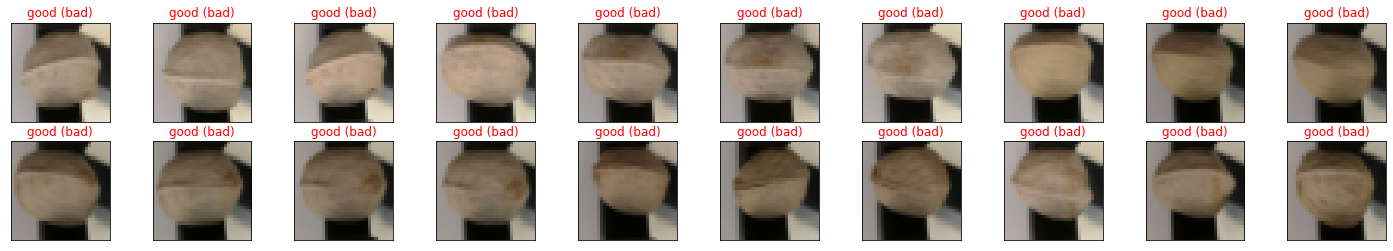

In [18]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])   
    # imshow(images[idx])   #This line was missing .cpu in the exercise version
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
    color=("green" if preds[idx]==labels[idx].item() else "red"))